# Quantum Compilation Hand-on

## Setup and Installation

To install MQT QMAP run:
```console
pip install mqt.qmap
```
in your preferred virtual environment.

In addition, you will need to install the `pyzx` package, if you have not done so yet.
```console
pip install pyzx
```

## Compilation using Qiskit -- The Qiskit Transpiler

Qiskit's transpiler is a crucial element known for its modularity and extensibility. Its primary objective is to facilitate the creation of new circuit transformations, referred to as transpiler passes, and combine them with existing passes. 
The order and chaining of these passes significantly influences the final outcome. 
To manage this process, a pass manager is employed, responsible for scheduling the passes and enabling communication among them through a shared space. 

In [1]:
import matplotlib.pyplot as plt
import math

import pyzx as zx

from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeAthensV2
from qiskit.visualization import plot_error_map

### Considered Architecture

Let's have a look at a specific architecture: in Qiskit we can import fake architectures which mimic real quantum computing hardware. One example is the 5-qubit "FakeAthensV2".

In [2]:
backend = FakeAthensV2()

In [3]:
backend.num_qubits

5

In [4]:
backend.operation_names

['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay']

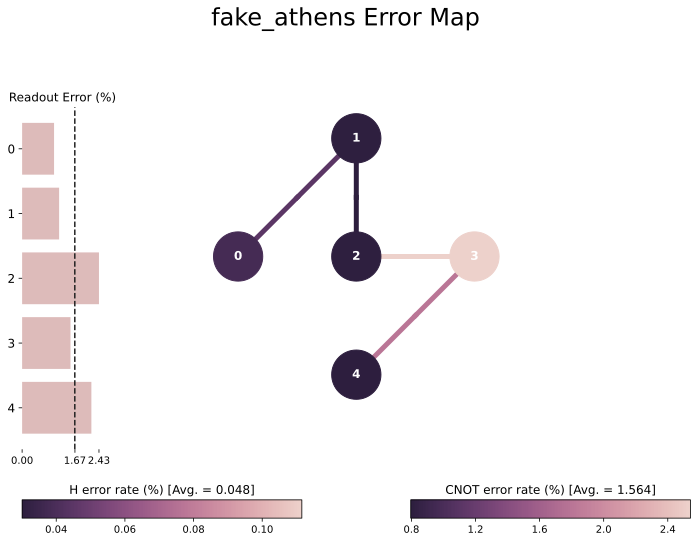

In [5]:
plot_error_map(backend)

### Considered Circuit

We will use a simple circuit to illustrate the effect of quantum circuit mapping.

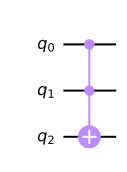

In [6]:
circ = QuantumCircuit(3)
circ.ccx(0, 1, 2)
circ.draw(output='mpl')

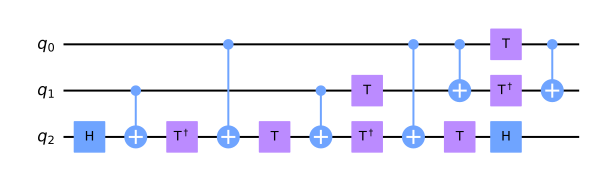

In [7]:
circ.decompose().draw(output='mpl')

### Decomposing the circuit to native gates

Let's see how to use the transpiler to decompose the circuit to native gates.

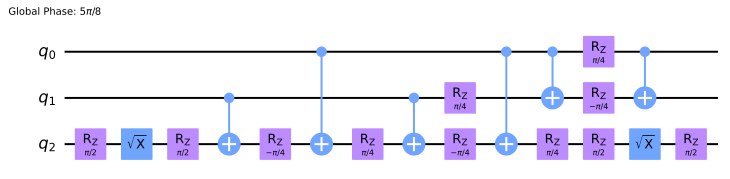

In [8]:
from qiskit.transpiler.preset_passmanagers.common import generate_translation_passmanager

tpm = generate_translation_passmanager(backend.target)
circ_native_gates = tpm.run(circ)
circ_native_gates.draw(output='mpl')

If we want to see all the possible transpiler passes

In [9]:
from qiskit.transpiler import passes
[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDuratio

#### Predefined Passes

Qiskit offers a range of predefined pass managers that cater to different optimization levels achieved through diverse pass pipelines. Currently, optimization levels 0 to 3 are supported, with higher numbers indicating increased optimization at the expense of additional time. Selecting an appropriate pass manager often involves trial and error, as it heavily relies on the specific circuit being transpiled and the target backend.

In the following illustration, we examine the different optimization levels using a state synthesis circuit. We begin by initializing four qubits to an arbitrary state and then proceed to optimize the circuit required to achieve this state.

- Optimization Level 0: This level solely maps the circuit to the backend, without any explicit optimization, except for any optimizations performed by the mapper.

- Optimization Level 1: Here, the circuit is mapped while incorporating lightweight optimizations that involve collapsing adjacent gates.

- Optimization Level 2: This level entails medium-weight optimization techniques, including a noise-adaptive layout and a gate-cancellation procedure based on the commutation relationships of the gates.

- Optimization Level 3: The most intensive level of optimization, encompassing all the steps from previous levels and additionally involving resynthesis of two-qubit gate blocks within the circuit.

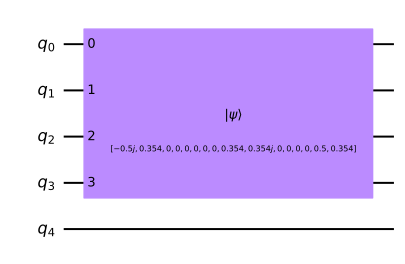

In [10]:
qc = QuantumCircuit(5)

random_state = [
    -1 / math.sqrt(4) * complex(0, 1),
    1 / math.sqrt(8) * complex(1, 0),
    0,
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(8) * complex(1, 0),
    1 / math.sqrt(8) * complex(0, 1),
    0,
    0,
    0,
    0,
    1 / math.sqrt(4) * complex(1, 0),
    1 / math.sqrt(8) * complex(1, 0)]

qc.initialize(random_state, range(4))
qc.draw(output='mpl')

In [11]:
opt_levels = [0, 1, 2, 3]
for opt_level in opt_levels:
    qc_opt = transpile(qc, backend=backend, seed_transpiler=7, optimization_level=opt_level)
    print(f"Optimization level {opt_level}: depth = {qc_opt.depth()},\t gates = {sorted(qc_opt.count_ops().items())}")

Optimization level 0: depth = 125,	 gates = [('cx', 58), ('reset', 4), ('rz', 60), ('sx', 30)]
Optimization level 1: depth = 100,	 gates = [('cx', 43), ('rz', 35), ('sx', 30)]
Optimization level 2: depth = 98,	 gates = [('cx', 41), ('rz', 35), ('sx', 30)]
Optimization level 3: depth = 99,	 gates = [('cx', 31), ('rz', 53), ('sx', 39), ('x', 1)]


# Time to analyze the effect of quantum circuit mapping

#### Qiskit implements the naive mapping via the BasicSwap PassManager.
We can use the BasicSwap PassManager to compile a circuit for the "FakeAthensV2" architecture with the help of its coupling list:

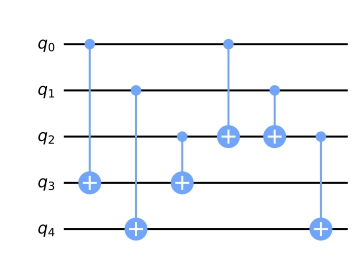

In [12]:
qc = QuantumCircuit(5)
qc.cnot(0, 3)
qc.cnot(1, 4)
qc.cnot(2, 3)
qc.cnot(0, 2)
qc.cnot(1, 2)
qc.cnot(2, 4)

qc.draw('mpl')

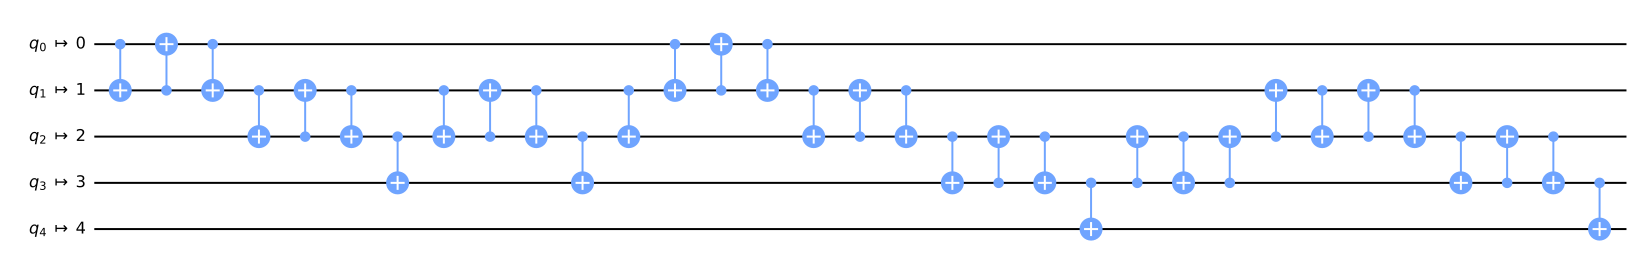

In [13]:
basic_circ = transpile(qc, backend=backend, seed_transpiler=7, layout_method='trivial', routing_method='basic')
basic_circ.draw('mpl', fold=-1)

### Qiskit offers a variety of Layout Selection methods.

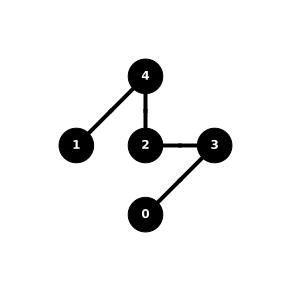

In [14]:
from qiskit.visualization import plot_circuit_layout

layout_method = 'sabre' # ['trivial', 'dense', 'noise_adaptive', 'sabre']
plot_circuit_layout(transpile(qc, backend=backend, seed_transpiler=7, layout_method=layout_method, routing_method='basic'), backend)

### Qiskit offers a variety of SWAP-insertions methods. 
Below, we show the swapper passes all applied to the same circuit, to transform it to match a linear chain topology.

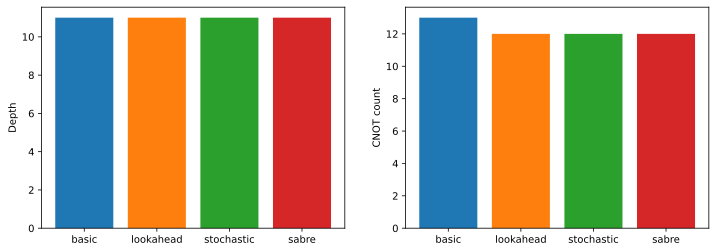

In [15]:
methods = ['basic', 'lookahead', 'stochastic', 'sabre']

# create a bar plot of the resulting depth and gate count for each method
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_ylabel('Depth')
axes[1].set_ylabel('CNOT count')
for method in methods:
    circ = transpile(qc, backend=backend, seed_transpiler=7, layout_method='sabre', routing_method=method)
    axes[0].bar(method, circ.depth(), label=method)
    axes[1].bar(method, circ.count_ops().get('cx', 0), label=method)

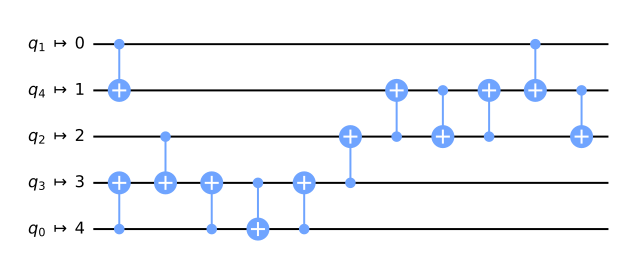

In [16]:
circ.draw('mpl')

## Next we want to investigate the functionality of QMAP.

### Exact Mapping
The exact mapper implemented in QMAP maps quantum circuits using the minimal number of SWAP gates. To this end, it encodes the mapping task as a MaxSAT problem and subsequently solves it using the SMT solver Z3. Due to the NP-hardness of the mapping task, this approach is only scalable up to roughly eight qubits in most scenarios.

Additional SWAPs: 2
Runtime:          0.098202


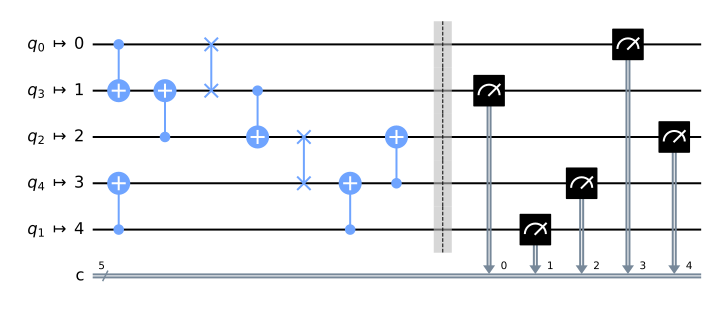

In [17]:
from mqt import qmap

qc_mapped, res = qmap.compile(qc, backend, method="exact", post_mapping_optimizations=False)
# qc_mapped = transpile(qc_mapped, backend=backend, seed_transpiler=7)
print("Additional SWAPs: %d" % res.output.swaps)
print("Runtime:          %f" % res.time)
qc_mapped.draw(output="mpl")

### Heuristic Mapping

The heuristic mapper implemented in QMAP uses A*-search to efficiently traverse the immense search space of the mapping problem. It effectively trades optimality for runtime. This allows to reliably determine suitable mappings for circuits with up to hundreds of qubits. Using the heuristic mapper works completely analogous to the exact mapper.

Additional SWAPs: 2
Runtime:          0.000046


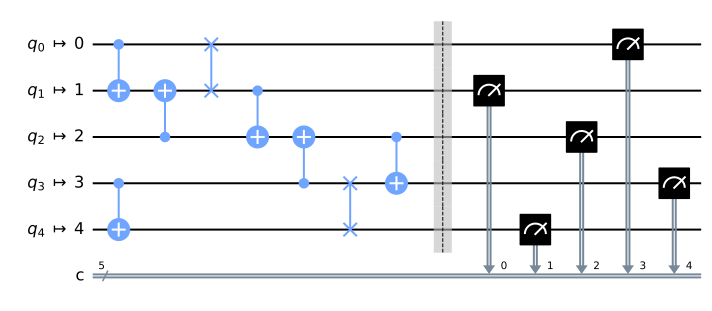

In [18]:
qc_mapped, res = qmap.compile(qc, backend, method="heuristic", post_mapping_optimizations=False, layering="disjoint_2q_blocks", initial_layout="identity")
print("Additional SWAPs: %d" % res.output.swaps)
print("Runtime:          %f" % res.time)
qc_mapped.draw(output="mpl")

## It is time for ZX!

In this section we introduce pyZX the library for manipulating and optimizing zx diagrams in python.
This is a standalone package and we will use for teaching purposes, but it is integrated in the optimization routines of the compiler TKET, of Quantinuum.

In [19]:
import random

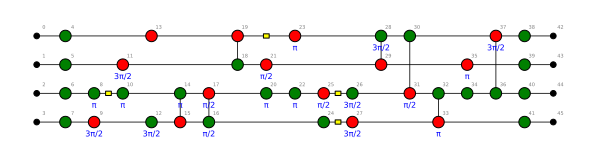

In [20]:
qubit_amount = 4
depth = 15
random.seed(1337)
circ = zx.generate.cliffords(qubit_amount, depth)
zx.draw_matplotlib(circ,labels=True,h_edge_draw='box')

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Internally this circuit is represented as a graph:

In [21]:
print(circ)
print("All edges: ", list(circ.edges()))
print("\nThe neighbors of a particular vertex: ", list(circ.neighbors(14)))

Graph(46 vertices, 49 edges)
All edges:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 13), (5, 11), (6, 8), (7, 9), (8, 10), (9, 12), (10, 14), (11, 18), (12, 15), (13, 19), (14, 15), (14, 17), (15, 16), (16, 17), (16, 24), (17, 20), (18, 19), (18, 21), (19, 23), (20, 22), (21, 29), (22, 25), (23, 28), (24, 27), (25, 26), (26, 31), (27, 33), (28, 29), (28, 30), (29, 35), (30, 31), (30, 37), (31, 32), (32, 33), (32, 34), (33, 41), (34, 36), (35, 39), (36, 37), (36, 40), (37, 38), (38, 42), (39, 43), (40, 44), (41, 45)]

The neighbors of a particular vertex:  [15, 10, 17]


Let us use ZX for simplifying the structure found

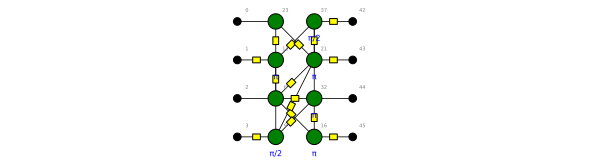

In [22]:
g = circ.copy()
zx.clifford_simp(g)
g.normalize() # Reposition nodes horizontally to look nicer
zx.draw_matplotlib(g,labels=True,h_edge_draw='box')


The blue lines represent edges that have a Hadamard gate on them.

Even though this graph is a lot compacter than the one we started out with, it no longer looks like a circuit. To fix this we need to be clever and *extract* a circuit from the ZX-diagram:

Circuit  on 4 qubits with 26 gates.
        0 is the T-count
        26 Cliffords among which
        11 2-qubit gates (0 CNOT, 11 other) and
        9 Hadamard gates.


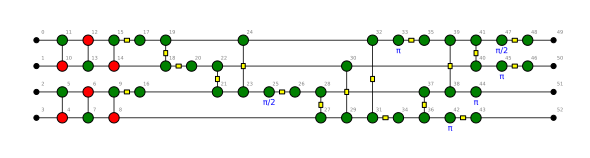

In [23]:
circ2 = g.copy()
circ2.normalize()
circ2 = zx.extract_circuit(circ2)
print(circ2.stats())
zx.draw_matplotlib(circ2,labels=True,h_edge_draw='box')

To validate the equivalence of the two circuits, we can convert them into numpy tensors and compare these tensors for equality. This comparison ensures that the circuit after the transformation remains identical to the original circuit.

In [24]:
t1 = circ.to_tensor()
t2 = circ2.to_tensor()
# This checks whether t1 and t2 are equal up to some number: t1 == z*t2 for some complex number z
zx.compare_tensors(t1,t2,preserve_scalar=False)

True

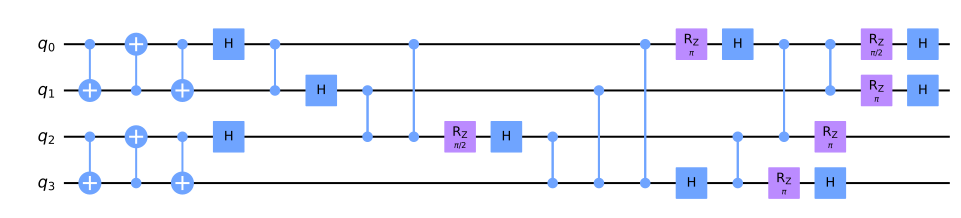

In [25]:
circ = QuantumCircuit.from_qasm_str(circ2.to_qasm())
circ.draw('mpl')

# Clifford Circuits and their Optimization

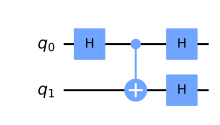

In [26]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.h(1)

qc.draw(output="mpl")

In [27]:
from qiskit.quantum_info import Clifford

cliff = Clifford.from_circuit(qc)
print(cliff)
print(cliff.to_operator())

# destabilizers tell about what happens when we start with other states than |0> e.g. |1>

Clifford: Stabilizer = ['+ZZ', '+XX'], Destabilizer = ['+IX', '+ZI']
Operator([[ 0.5+0.5j,  0. +0.j ,  0.5+0.5j,  0. +0.j ],
          [ 0. +0.j ,  0.5+0.5j,  0. +0.j ,  0.5+0.5j],
          [ 0. +0.j ,  0.5+0.5j,  0. +0.j , -0.5-0.5j],
          [ 0.5+0.5j,  0. +0.j , -0.5-0.5j,  0. +0.j ]],
         input_dims=(2, 2), output_dims=(2, 2))


Clifford: Stabilizer = ['+ZZ', '+XX'], Destabilizer = ['-IX', '+ZI']
Operator([[ 0.5+0.5j,  0. +0.j ,  0.5+0.5j,  0. +0.j ],
          [ 0. +0.j , -0.5-0.5j,  0. +0.j , -0.5-0.5j],
          [ 0. +0.j , -0.5-0.5j,  0. +0.j ,  0.5+0.5j],
          [ 0.5+0.5j,  0. +0.j , -0.5-0.5j,  0. +0.j ]],
         input_dims=(2, 2), output_dims=(2, 2))


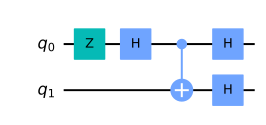

In [28]:
qc_alt = QuantumCircuit(2)
qc_alt.z(0)
qc_alt.h(0)
qc_alt.cx(0, 1)
qc_alt.h(0)
qc_alt.h(1)

cliff_alt = Clifford.from_circuit(qc_alt)
print(cliff_alt)
print(cliff_alt.to_operator())

qc_alt.draw(output="mpl")

# are those circuits the same for one input or all inputs

## Using QMAP for Optimal Clifford Synthesis

### Starting from an initial circuit

Original circuit depth: 4
Depth: 2, Runtime: 0.022536499


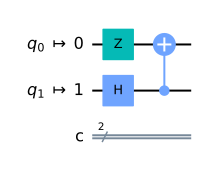

In [34]:
from qiskit import QuantumCircuit
from mqt import qmap

qc = QuantumCircuit(2)
qc.z(0)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.h(1)
print(f"Original circuit depth: {qc.depth()}")
qc.draw(output="mpl")

qc_opt, results = qmap.optimize_clifford(circuit=qc, use_maxsat=True, include_destabilizers=True)

print(f"Depth: {results.depth}, Runtime: {results.runtime}")
qc_opt.draw(output="mpl")

### Increasing scalability by resorting to heuristic methods

Original circuit depth: 6
Depth: 5, Runtime: 0.0


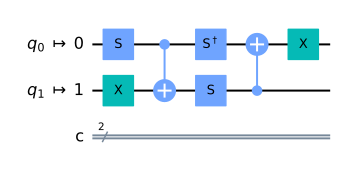

In [30]:
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0, 1)
qc.x(0)
qc.s(1)
qc.x(1)
qc.cx(1, 0)
qc.x(1)
print(f"Original circuit depth: {qc.depth()}")

qc_opt, results = qmap.optimize_clifford(
    circuit=qc, heuristic=True, split_size=3, include_destabilizers=True, target_metric="depth"
)
print(f"Depth: {results.depth}, Runtime: {results.runtime}")

qc_opt.draw(output="mpl")

Depth: 4, Runtime: 0.087305721


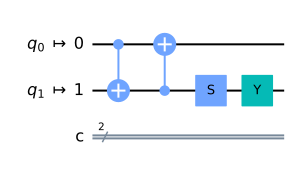

In [31]:
qc_opt, results = qmap.optimize_clifford(circuit=qc, heuristic=False, include_destabilizers=True, target_metric="depth")
print(f"Depth: {results.depth}, Runtime: {results.runtime}")

# larger block size for larger circuits
qc_opt.draw(output="mpl")

### Starting from a functional description

Clifford: Stabilizer = ['-ZZ', '+IZ'], Destabilizer = ['+YI', '+YX']
Depth: 4, Runtime: 0.062169626


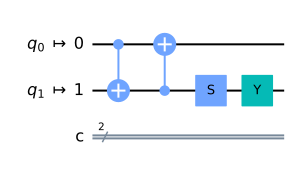

In [32]:
cliff = Clifford.from_circuit(qc)
print(cliff)

qc_opt, results = qmap.synthesize_clifford(target_tableau=cliff, include_destabilizers=True, target_metric="depth")
print(f"Depth: {results.depth}, Runtime: {results.runtime}")

qc_opt.draw(output="mpl")